<a href="https://colab.research.google.com/github/ihawryluk/importations/blob/main/Double_spike_analyse_results_posteriors_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# SET THE WRITE PROPERTY BEFORE YOU RUN THIS SCRIPT

Decide if you want to overwrite the saved plots or not

In [71]:
SAVE = True
savepath = '/content/drive/My Drive/Colab Notebooks/importations/Figures/Double_spike/'

# Install and import packages

In [2]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 2.3 MB/s eta 0:00:00


In [3]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 1.1 MB/s eta 0:00:00


In [4]:
!pip install properscoring

In [5]:
!pip install CRPS

In [6]:
import numpyro
import jax
numpyro.set_host_device_count(4)  # 4 cores
from jax import vmap
import jax.numpy as jnp
import jax.random as random

from numpyro.infer import Predictive
import numpyro.distributions as dist
import arviz as az
from numpyro.infer import MCMC, NUTS
from numpyro.contrib.control_flow import scan

from scipy.stats import gamma
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import arviz as az
import dill
from properscoring import crps_ensemble as crps
# import CRPS.CRPS as crps

from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import mean_squared_error as mse

Mounted at /content/drive


# Load all simulated data and results

In [7]:
ls /content/drive/MyDrive/Colab\ Notebooks/importations/Data/Double_spike/

mcmc_10a.pkl  mcmc_1a.pkl  mcmc_4a.pkl  mcmc_7a.pkl  sim_double_spike_mu.csv
mcmc_10.pkl   mcmc_1.pkl   mcmc_4.pkl   mcmc_7.pkl   sim_double_spike_Rt.csv
mcmc_11a.pkl  mcmc_2a.pkl  mcmc_5a.pkl  mcmc_8a.pkl  sim_double_spike_y.csv
mcmc_11.pkl   mcmc_2.pkl   mcmc_5.pkl   mcmc_8.pkl
mcmc_12a.pkl  mcmc_3a.pkl  mcmc_6a.pkl  mcmc_9a.pkl
mcmc_12.pkl   mcmc_3.pkl   mcmc_6.pkl   mcmc_9.pkl


In [8]:
path = '/content/drive/My Drive/Colab Notebooks/importations/Data/Double_spike/'

In [9]:
mu_df = pd.read_csv(path + 'sim_double_spike_mu.csv')
y_df = pd.read_csv(path + 'sim_double_spike_y.csv')
Rt_df = pd.read_csv(path + 'sim_double_spike_Rt.csv')


In [10]:
# high variance model results
with open(path + 'mcmc_1.pkl', 'rb') as f:
    mcmc1 = dill.load(f)
with open(path + 'mcmc_2.pkl', 'rb') as f:
    mcmc2 = dill.load(f)
with open(path + 'mcmc_3.pkl', 'rb') as f:
    mcmc3 = dill.load(f)
with open(path + 'mcmc_4.pkl', 'rb') as f:
    mcmc4 = dill.load(f)
with open(path + 'mcmc_5.pkl', 'rb') as f:
    mcmc5 = dill.load(f)
with open(path + 'mcmc_6.pkl', 'rb') as f:
    mcmc6 = dill.load(f)
with open(path + 'mcmc_7.pkl', 'rb') as f:
    mcmc7 = dill.load(f)
with open(path + 'mcmc_8.pkl', 'rb') as f:
    mcmc8 = dill.load(f)
with open(path + 'mcmc_9.pkl', 'rb') as f:
    mcmc9 = dill.load(f)
with open(path + 'mcmc_10.pkl', 'rb') as f:
    mcmc10 = dill.load(f)
with open(path + 'mcmc_11.pkl', 'rb') as f:
    mcmc11 = dill.load(f)
with open(path + 'mcmc_12.pkl', 'rb') as f:
    mcmc12 = dill.load(f)

In [11]:
# low variance model results
with open(path + 'mcmc_1a.pkl', 'rb') as f:
    mcmc1a = dill.load(f)
with open(path + 'mcmc_2a.pkl', 'rb') as f:
    mcmc2a = dill.load(f)
with open(path + 'mcmc_3a.pkl', 'rb') as f:
    mcmc3a = dill.load(f)
with open(path + 'mcmc_4a.pkl', 'rb') as f:
    mcmc4a = dill.load(f)
with open(path + 'mcmc_5a.pkl', 'rb') as f:
    mcmc5a = dill.load(f)
with open(path + 'mcmc_6a.pkl', 'rb') as f:
    mcmc6a = dill.load(f)
with open(path + 'mcmc_7a.pkl', 'rb') as f:
    mcmc7a = dill.load(f)
with open(path + 'mcmc_8a.pkl', 'rb') as f:
    mcmc8a = dill.load(f)
with open(path + 'mcmc_9a.pkl', 'rb') as f:
    mcmc9a = dill.load(f)
with open(path + 'mcmc_10a.pkl', 'rb') as f:
    mcmc10a = dill.load(f)
with open(path + 'mcmc_11a.pkl', 'rb') as f:
    mcmc11a = dill.load(f)
with open(path + 'mcmc_12a.pkl', 'rb') as f:
    mcmc12a = dill.load(f)

In [12]:
scenarios_names = ['placeholder',
                   r'second spike when $R_t$ decreasing, equal spikes',
                   r'second spike when $R_t$ decreasing, first spike higher',
                   r'second spike when $R_t$ decreasing, second spike higher, $\mu_2 = 150$',
                   r'second spike when $R_t$ decreasing, second spike higher, $\mu_2 = 300$',
                   r'second spike when $R_t$ increasing but inc ~ 0, equal spikes',
                   r'second spike when $R_t$ increasing but inc ~ 0, first spike higher',
                   r'second spike when $R_t$ increasing but inc ~ 0, second spike higher, $\mu_2 = 150$',
                   r'second spike when $R_t$ increasing but inc ~ 0, second spike higher, $\mu_2 = 300$',
                  r'second spike when $R_t$ increasing, equal spikes',
                   r'second spike when $R_t$ increasing, first spike higher',
                   r'second spike when $R_t$ increasing, second spike higher, $\mu_2 = 150$',
                   r'second spike when $R_t$ increasing, second spike higher, $\mu_2 = 300$'
                   ]

# Parameters only posteriors

In [17]:
mcmc1.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    R_d[0]      0.05      0.23      0.05     -0.34      0.42  16137.79      1.00
    R_d[1]      0.09      0.30      0.10     -0.39      0.59  13440.98      1.00
    R_d[2]      0.14      0.32      0.15     -0.38      0.66   8789.67      1.00
    R_d[3]      0.23      0.33      0.24     -0.31      0.77   8613.85      1.00
    R_d[4]      0.26      0.32      0.27     -0.26      0.78   8879.67      1.00
    R_d[5]      0.34      0.31      0.35     -0.17      0.84  13255.06      1.00
    R_d[6]      0.41      0.26      0.42      0.01      0.85   9560.50      1.00
    R_d[7]      0.57      0.18      0.58      0.30      0.86  13168.90      1.00
    R_d[8]      0.67      0.15      0.68      0.44      0.92  10394.33      1.00
    R_d[9]      0.70      0.14      0.71      0.48      0.93  15709.43      1.00
   R_d[10]      0.52      0.12      0.52      0.32      0.72  13634.06      1.00
   R_d[11]      0.68      0

In [22]:
def plot_pairs_single_model(mcmc):
  mcmc_az = az.from_numpyro(mcmc)
  az.plot_pair(
      mcmc,
      var_names=["sigma_R", "sigma_mu", "temp", "theta"],
      divergences=True)

  plt.show()

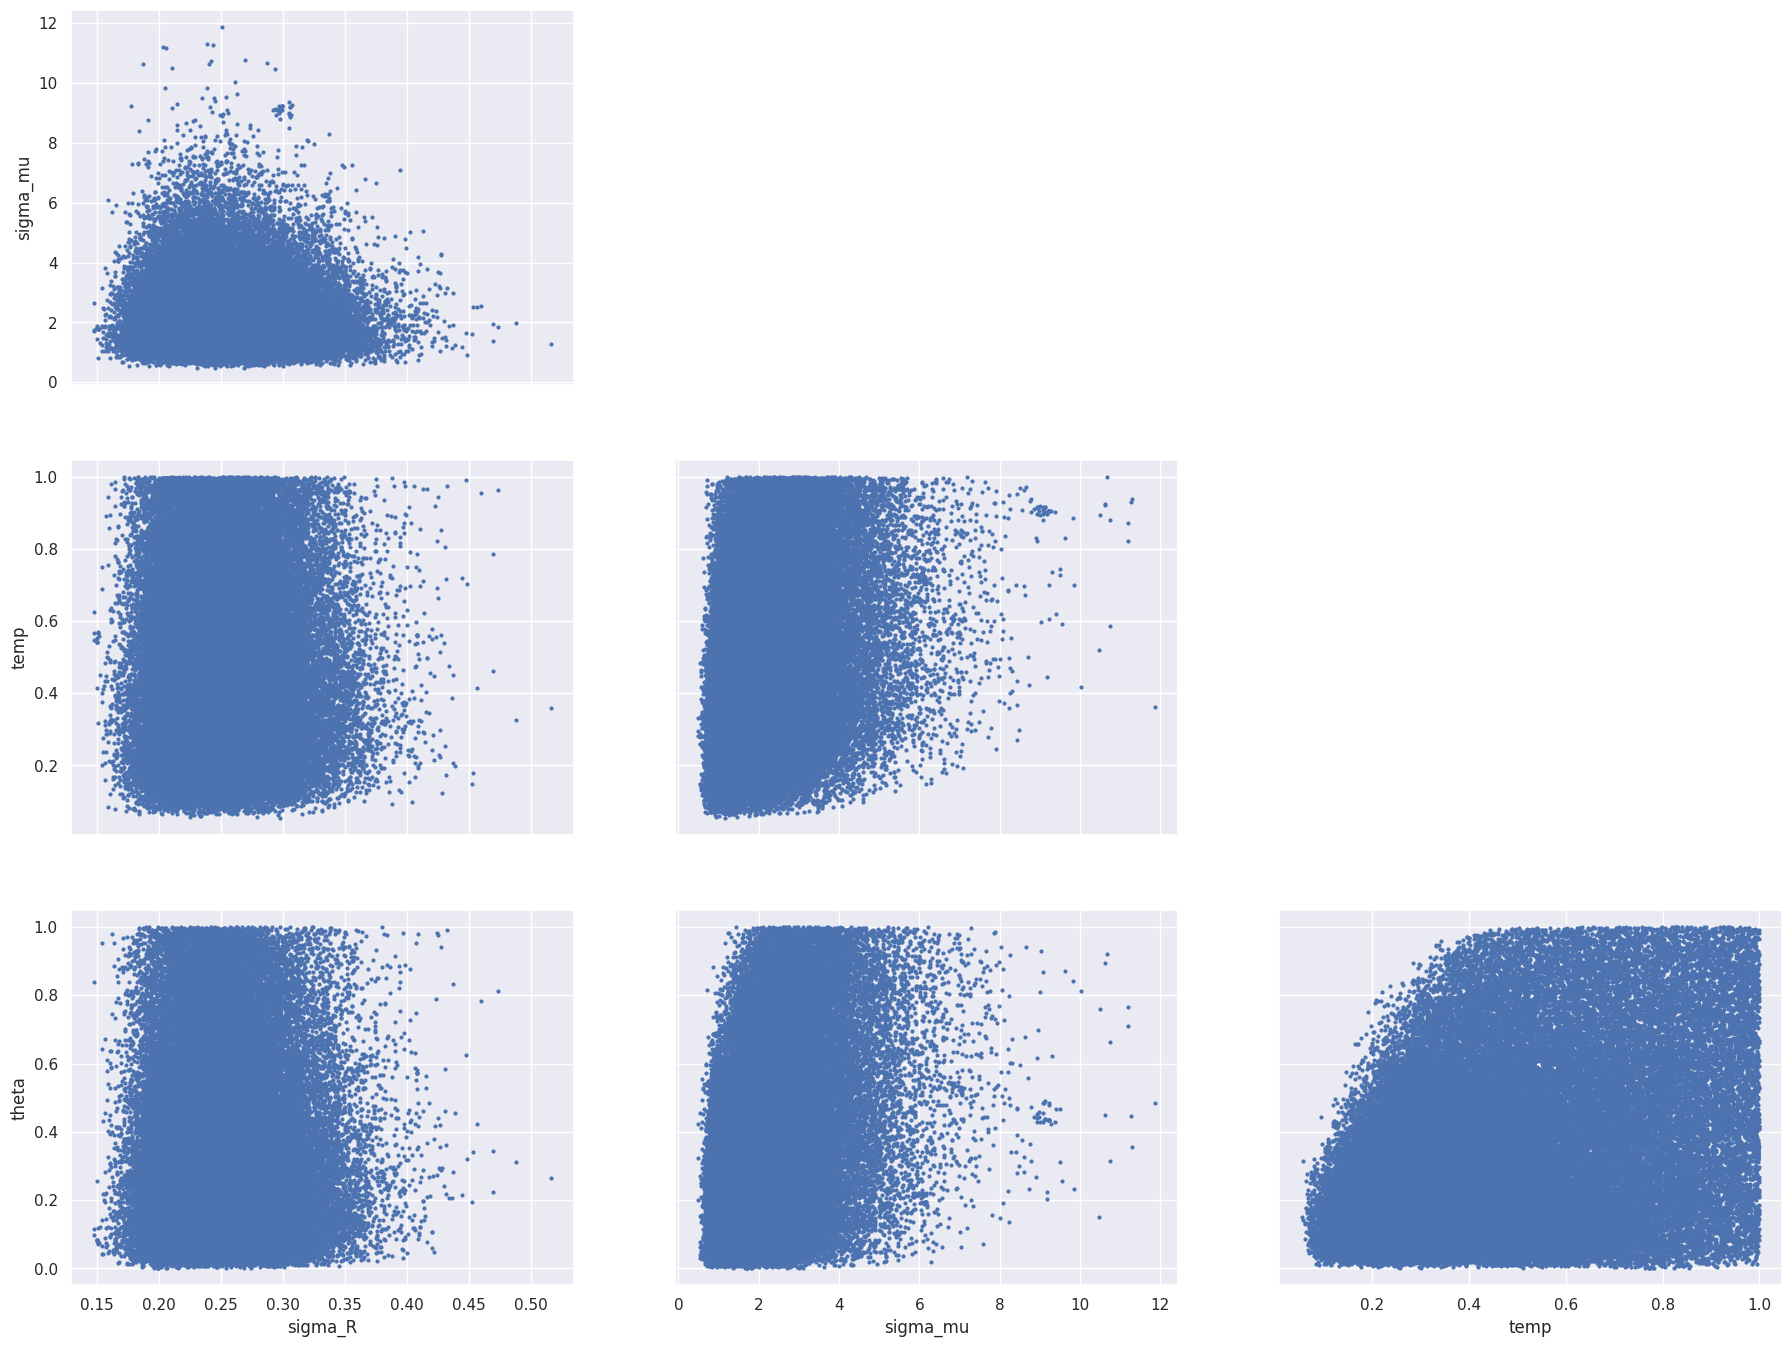

In [25]:
plot_pairs_single_model(mcmc1)
# plot_pairs_single_model(mcmc1a)


In [32]:
mcmc1.get_samples()['sigma_mu'].shape

(80000,)

In [39]:
mcmc1.get_samples().keys()

dict_keys(['R', 'R_d', 'bin_mu', 'incidence', 'mu', 'mu_d', 'sigma_R', 'sigma_mu', 'temp', 'theta'])

In [87]:
print(sns.color_palette("deep").as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


In [93]:
def plot_single_param(param, mcmc_high, mcmc_low):
  plt.hist(mcmc_high.get_samples()[param], label='high var', alpha=0.5, color='#4c72b0')
  plt.axvline(x = np.median(mcmc_high.get_samples()[param]), color='#4c72b0')
  plt.hist(mcmc_low.get_samples()[param], label='low var', alpha=0.5, color='#dd8452')
  plt.axvline(x = np.median(mcmc_low.get_samples()[param]), color='#dd8452')
  plt.yticks([])  # Command for hiding y-axis
  plt.legend()
  p = param.replace('sigma_R','$\sigma_R$').replace('sigma_mu','$\sigma_\mu$').replace('theta','$\\theta_\mu$')
  plt.xlabel(p)
  plt.tight_layout()

def plot_all_params(mcmc_high, mcmc_low, title):
  param_list = ['sigma_R', 'sigma_mu', 'temp', 'theta']
  plt.figure(figsize=(10,2.5))
  for i in range(0,len(param_list)):
    plt.subplot(1,4,i+1)
    plot_single_param(param_list[i], mcmc_high, mcmc_low)
  plt.suptitle(title)
  plt.tight_layout()

  if SAVE:
    namefile = 'params_post_' + title.replace(' ', '_')
    plt.savefig(savepath + namefile + '.pdf', format = 'pdf', bbox_inches = 'tight')

  else:
    plt.show()

  # plt.show()


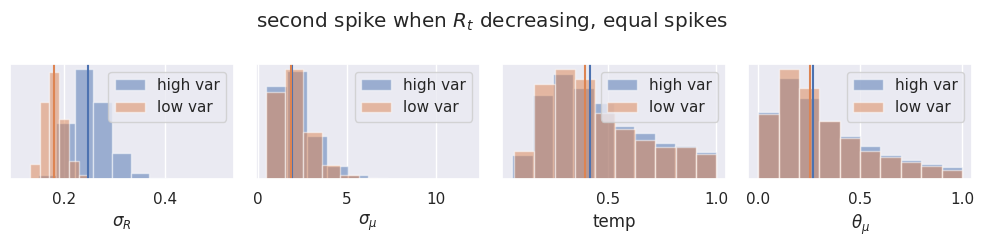

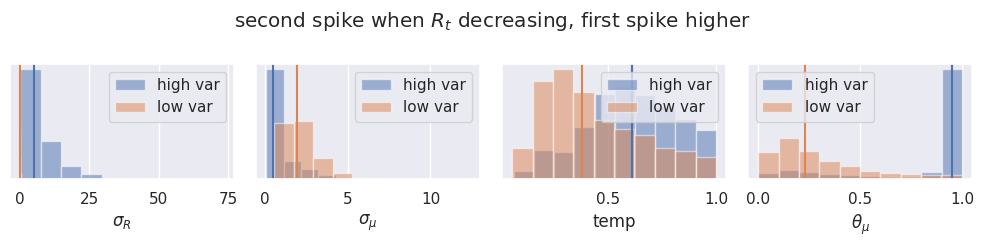

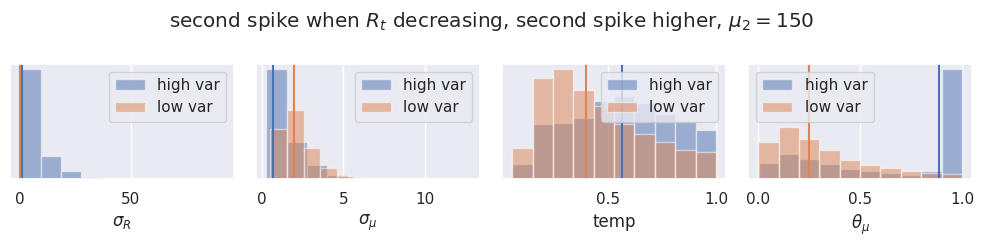

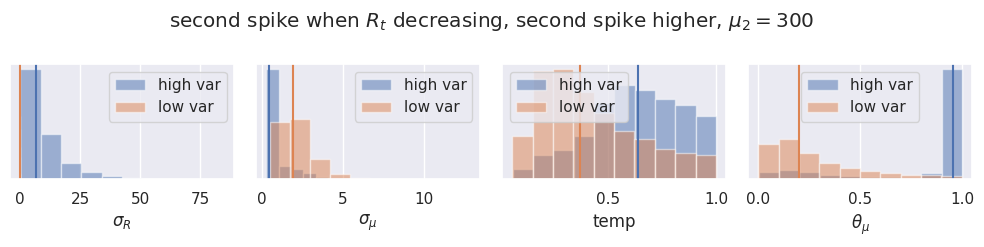

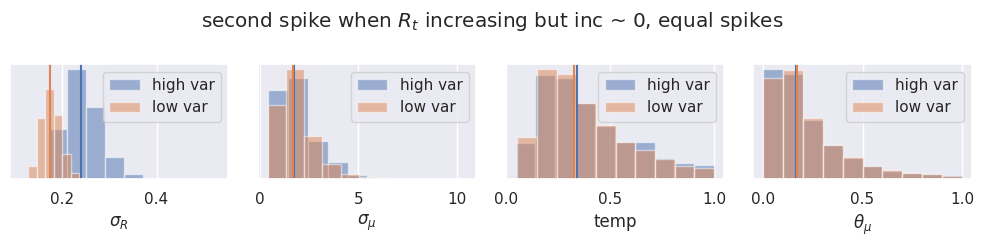

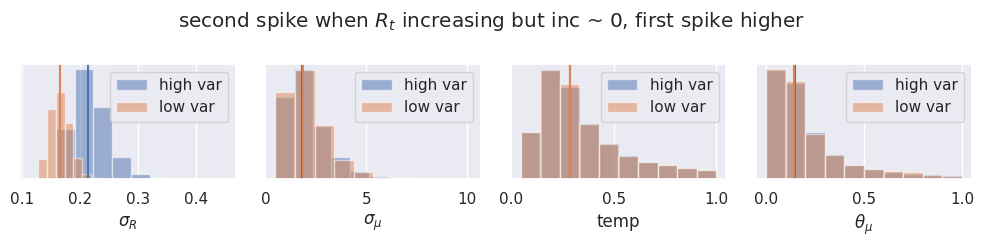

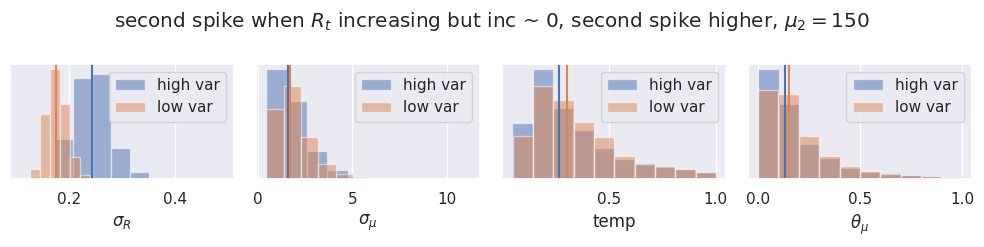

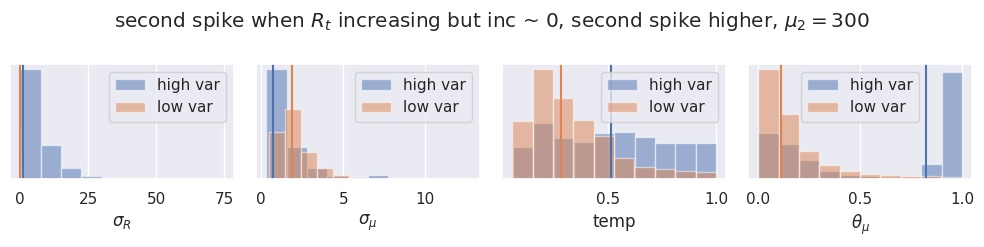

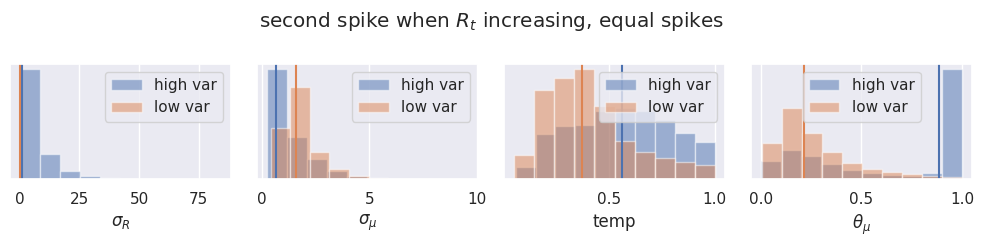

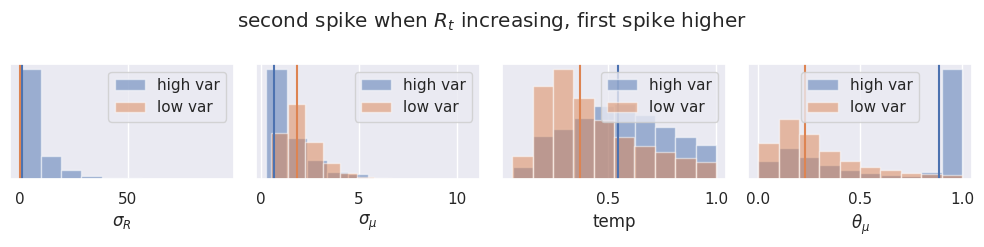

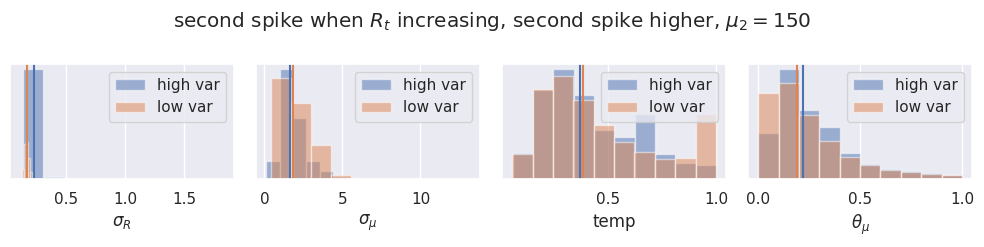

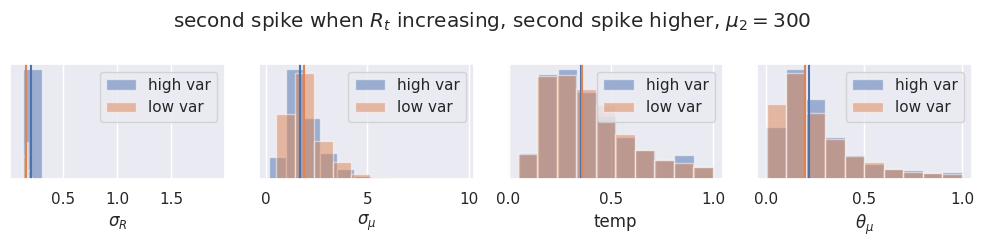

In [94]:
plot_all_params(mcmc1, mcmc1a, scenarios_names[1])
plot_all_params(mcmc2, mcmc2a, scenarios_names[2])
plot_all_params(mcmc3, mcmc3a, scenarios_names[3])

plot_all_params(mcmc4, mcmc4a, scenarios_names[4])
plot_all_params(mcmc5, mcmc5a, scenarios_names[5])
plot_all_params(mcmc6, mcmc6a, scenarios_names[6])

plot_all_params(mcmc7, mcmc7a, scenarios_names[7])
plot_all_params(mcmc8, mcmc8a, scenarios_names[8])
plot_all_params(mcmc9, mcmc9a, scenarios_names[9])

plot_all_params(mcmc10, mcmc10a, scenarios_names[10])
plot_all_params(mcmc11, mcmc11a, scenarios_names[11])
plot_all_params(mcmc12, mcmc12a, scenarios_names[12])